In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
import warnings, re, joblib
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
#from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from scipy.stats import probplot
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PowerTransformer, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import scipy.stats as stat
import pylab

import pandas as pd
import numpy as np

In [3]:
data_train = pd.read_csv("/content/drive/MyDrive/Credit Score/train.csv")

In [4]:
def text_cleaning(data):
    if data is np.NaN or not isinstance(data, str):
        return data
    else:
        return str(data).strip('_ ,"')

data_train = data_train.applymap(text_cleaning).replace(['', 'nan', '!@9#%8', '#F%$D@*&8'], np.NaN)


In [5]:
# The features "Delay_from_due_date" and "Num_Bank_Accounts" have negative values which is not possible.
data_train = data_train[data_train.Delay_from_due_date >= 0]
data_train = data_train[data_train.Num_Bank_Accounts >= 0]


#check for categorical variables
cat_cols = data_train.select_dtypes(include=['object']).columns
#Missing values
data_train.isnull().sum()

#check for percentage of missing values in each column
data_train.isnull().sum()/len(data_train)*100

ID                           0.000000
Customer_ID                  0.000000
Month                        0.000000
Name                         9.975047
Age                          0.000000
SSN                          5.563046
Occupation                   7.050147
Annual_Income                0.000000
Monthly_Inhand_Salary       14.997786
Num_Bank_Accounts            0.000000
Num_Credit_Card              0.000000
Interest_Rate                0.000000
Num_of_Loan                  0.000000
Type_of_Loan                11.338391
Delay_from_due_date          0.000000
Num_of_Delayed_Payment       7.007888
Changed_Credit_Limit         2.096833
Num_Credit_Inquiries         1.963014
Credit_Mix                  20.202640
Outstanding_Debt             0.000000
Credit_Utilization_Ratio     0.000000
Credit_History_Age           9.019197
Payment_of_Min_Amount        0.000000
Total_EMI_per_month          0.000000
Amount_invested_monthly      4.482432
Payment_Behaviour            7.597497
Monthly_Bala

In [6]:
#Treat credit history age
def Month_Converter(x):
    if pd.notnull(x):
        Year = int(x.split(' ')[0])
        Month = int(x.split(' ')[3])
        Month = Month/12

        return Year+Month
    else:
        return x

data_train['Credit_History_Age'] = data_train['Credit_History_Age'].apply(Month_Converter)


In [7]:
#write a function to loop over all columns and remove any special characters
def removeSpecialChar(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.replace('[^A-Za-z0-9]+','')
    return data

data_train = removeSpecialChar(data_train)

In [8]:
#Deal with missing values
missingDataCol = ['Monthly_Inhand_Salary','Num_of_Delayed_Payment','Num_Credit_Inquiries','Credit_History_Age','Amount_invested_monthly','Monthly_Balance', 'Changed_Credit_Limit']


#Convert datatype to float
for col in missingDataCol:
    if data_train[col].dtype == 'object':
        #data_train[col] = data_train[col].str.replace('[^A-Za-z0-9]+','')
        data_train[col] = data_train[col].astype(float)


#fill missing values with mean for columns - 'Monthly_Inhand_Salary','Num_of_Delayed_Payment','Num_Credit_Inquiries','Credit_History_Age','Amount_invested_monthly','Monthly_Balance'
for col in missingDataCol:
    data_train[col].fillna(data_train[col].mean(),inplace=True)

#Remove blank values from column - 'Changes_Credit_Limit' and replace them with NAN
data_train['Changed_Credit_Limit'].replace('',np.nan,inplace=True)

data_train['Changed_Credit_Limit'].fillna(data_train['Changed_Credit_Limit'].mean(),inplace=True)

#fill missing values with mode for column - 'Type_of_Loan'
data_train['Type_of_Loan'].fillna(data_train['Type_of_Loan'].mode()[0],inplace=True)
data_train['Occupation'].fillna(data_train['Occupation'].mode()[0],inplace=True)
data_train['Credit_Mix'].fillna(data_train['Credit_Mix'].mode()[0],inplace=True)
data_train['Payment_Behaviour'].fillna(data_train['Payment_Behaviour'].mode()[0],inplace=True)


In [9]:
#check for missing values
data_train.isnull().sum()

#apply vlookup to fill in the missing names with respective customer id
#data_train['Name'] = data_train['Name'].map(data_train.set_index('Customer_ID')['Name'])


#Fix the data types
data_train['ID']                      = data_train.ID.apply(lambda x: int(x, 16))
#data_train['Customer_ID']             = data_train.Customer_ID.apply(lambda x: int(x[4:], 16))
data_train['Month']                   = pd.to_datetime(data_train.Month, format='%B').dt.month
data_train['Age']                     = data_train.Age.astype(int)
#data_train['SSN']                     = data_train.SSN.apply(lambda x: x if x is np.NaN else int(str(x).replace('-', ''))).astype(float)
data_train['Annual_Income']           = data_train.Annual_Income.astype(float)
data_train['Num_of_Loan']             = data_train.Num_of_Loan.astype(int)
data_train['Num_of_Delayed_Payment']  = data_train.Num_of_Delayed_Payment.astype(float)
data_train['Changed_Credit_Limit']    = data_train.Changed_Credit_Limit.astype(float)
data_train['Outstanding_Debt']        = data_train.Outstanding_Debt.astype(float)
data_train['Amount_invested_monthly'] = data_train.Amount_invested_monthly.astype(float)
data_train['Monthly_Balance']         = data_train.Monthly_Balance.astype(float)


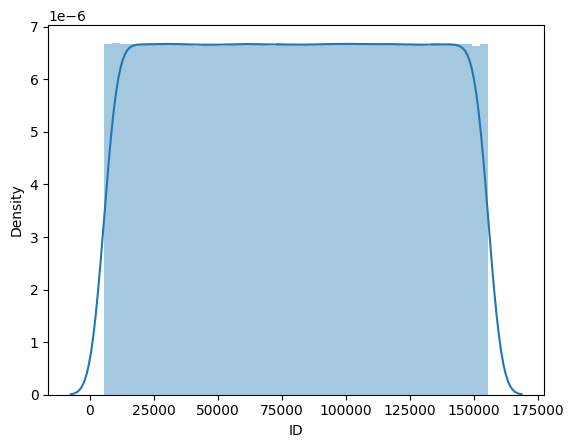

ID
Skewness :  1.91688492386799e-06
Kurtosis :  -1.2000224035674565
--------------------------------------------------


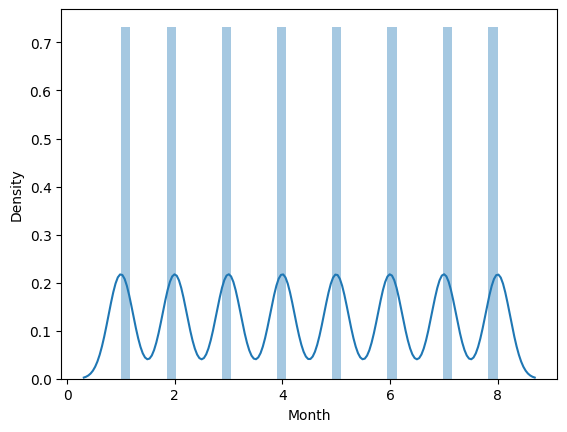

Month
Skewness :  0.0002625624664409147
Kurtosis :  -1.2380094633089969
--------------------------------------------------


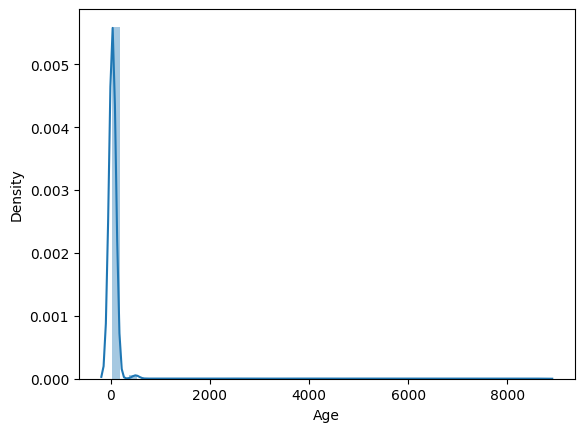

Age
Skewness :  9.230450784312936
Kurtosis :  89.54598840614905
--------------------------------------------------


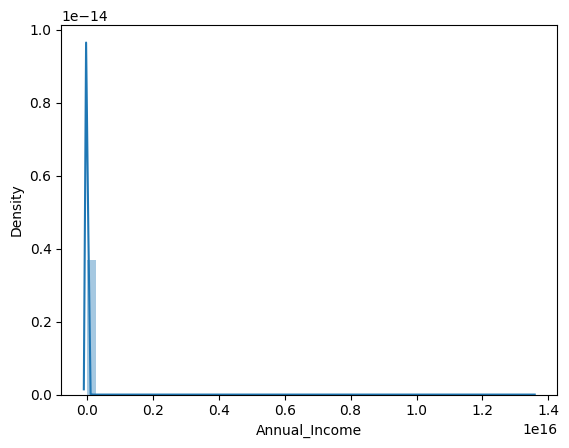

Annual_Income
Skewness :  28.343193577095
Kurtosis :  866.1989165937314
--------------------------------------------------


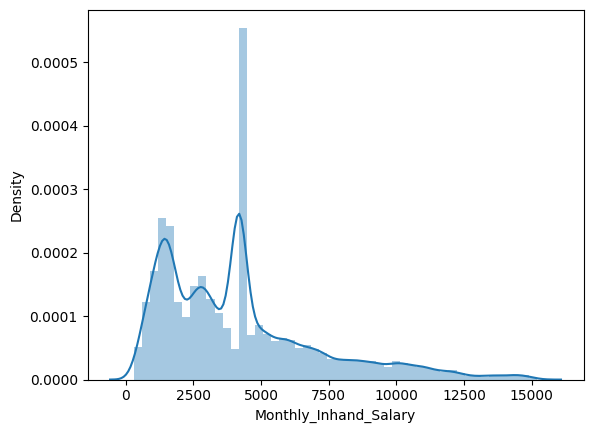

Monthly_Inhand_Salary
Skewness :  1.2253242534237734
Kurtosis :  1.2642394181792311
--------------------------------------------------


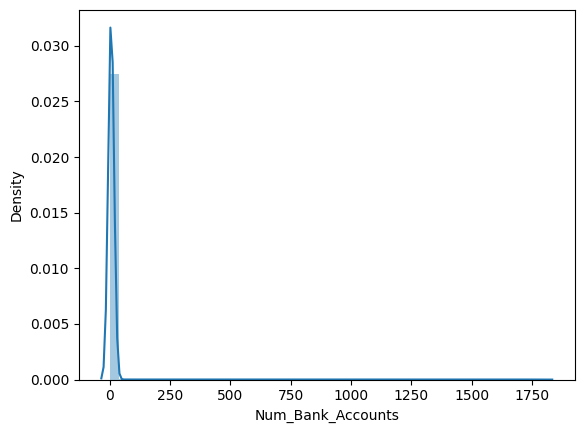

Num_Bank_Accounts
Skewness :  11.203154969101302
Kurtosis :  132.54303640103976
--------------------------------------------------


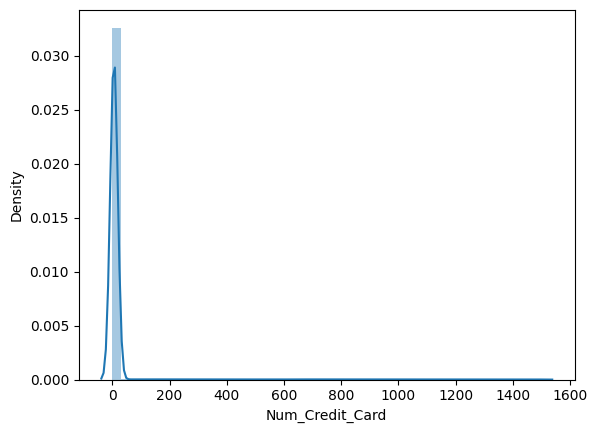

Num_Credit_Card
Skewness :  8.461639049589559
Kurtosis :  74.59934574253393
--------------------------------------------------


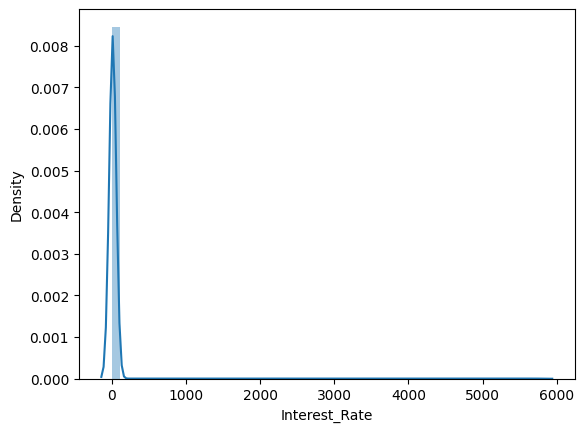

Interest_Rate
Skewness :  9.0069520313847
Kurtosis :  85.20332631801504
--------------------------------------------------


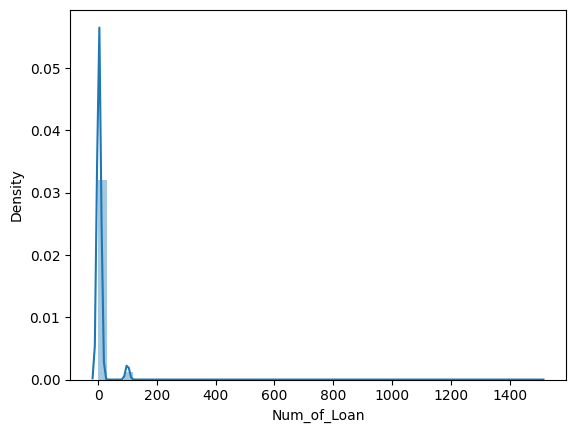

Num_of_Loan
Skewness :  16.59990049217688
Kurtosis :  317.064117059527
--------------------------------------------------


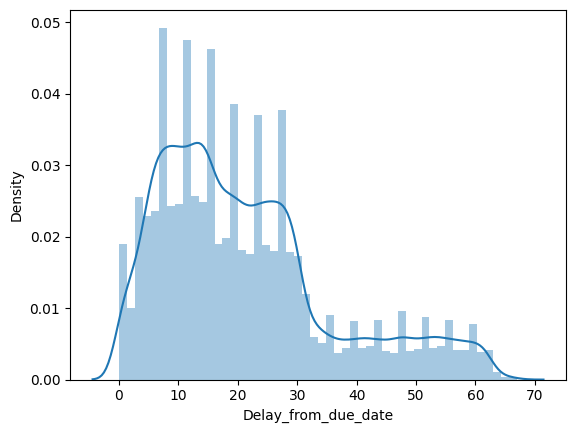

Delay_from_due_date
Skewness :  0.9802816782055186
Kurtosis :  0.3534575301144458
--------------------------------------------------


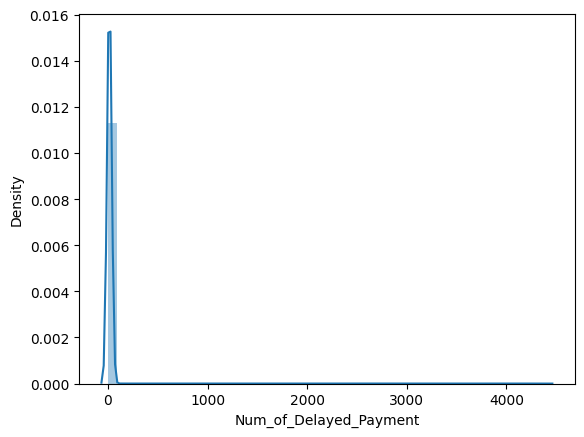

Num_of_Delayed_Payment
Skewness :  14.90448171005208
Kurtosis :  235.86377938256643
--------------------------------------------------


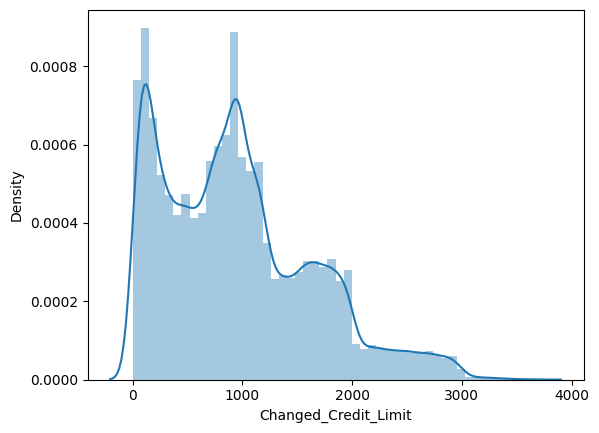

Changed_Credit_Limit
Skewness :  0.738429462568581
Kurtosis :  0.07939937694286181
--------------------------------------------------


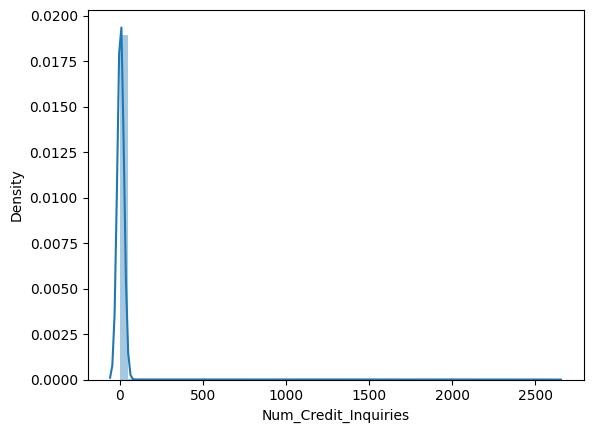

Num_Credit_Inquiries
Skewness :  9.89341653304659
Kurtosis :  102.87330711028375
--------------------------------------------------


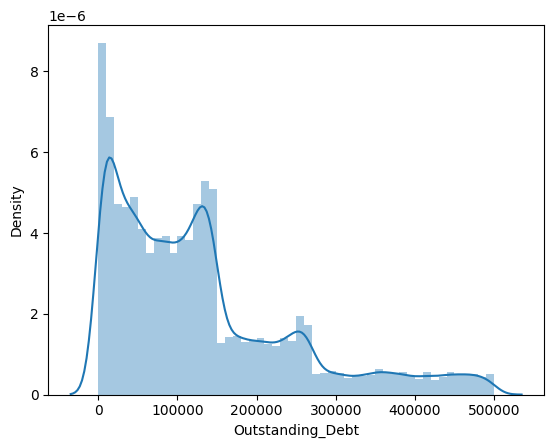

Outstanding_Debt
Skewness :  1.2599220735239913
Kurtosis :  1.078554448678195
--------------------------------------------------


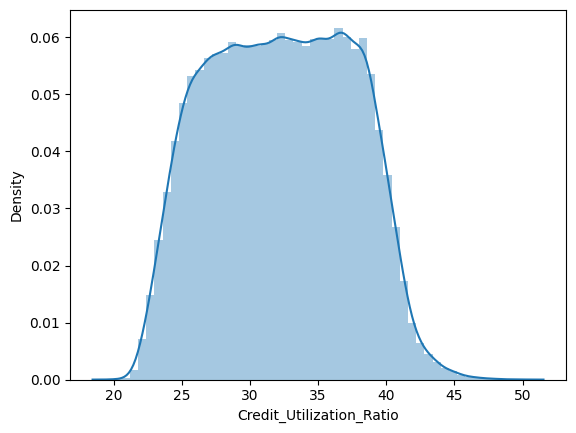

Credit_Utilization_Ratio
Skewness :  0.028241520973416766
Kurtosis :  -0.9451947720959306
--------------------------------------------------


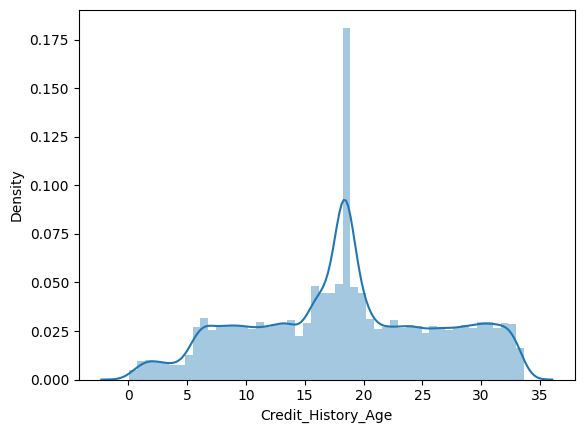

Credit_History_Age
Skewness :  -0.04512753367382258
Kurtosis :  -0.6984019896024236
--------------------------------------------------


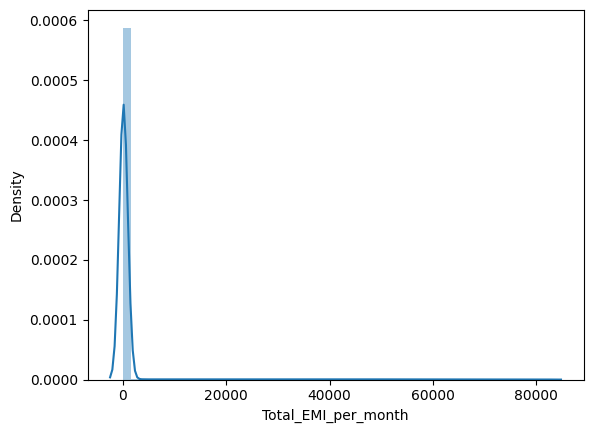

Total_EMI_per_month
Skewness :  7.0979764531380765
Kurtosis :  52.158560003558314
--------------------------------------------------


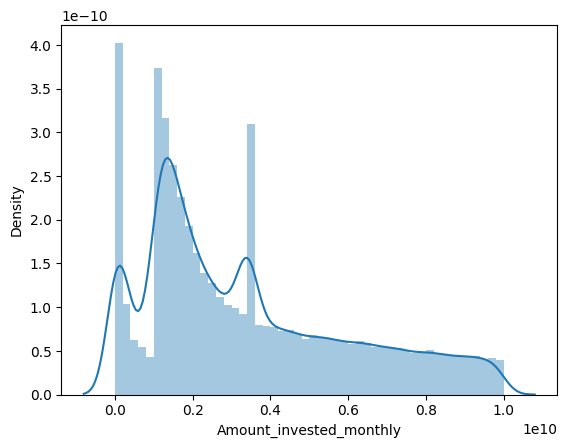

Amount_invested_monthly
Skewness :  0.7813357479870782
Kurtosis :  -0.42390413145226225
--------------------------------------------------


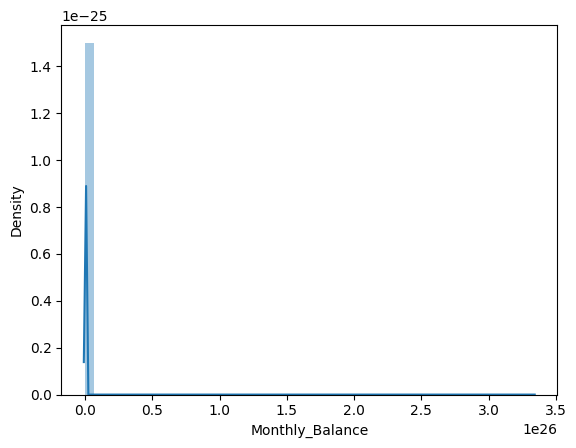

Monthly_Balance
Skewness :  105.0730978414048
Kurtosis :  11038.60754452995
--------------------------------------------------


In [10]:
#test for skewness in data
for col in data_train.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(data_train[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")


In [ ]:
#DO NOT RUN THIS CELL
#check whether feature is normally distributed
def plot_data(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()


for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)

skewed_cols = ['Annual_Income','Num_of_Delayed_Payment','Monthly_Balance','Total_EMI_per_month','Credit_Utilization_Ratio','Num_Credit_Inquiries','Delay_from_due_date','Interest_Rate','Num_Credit_Card','Num_Bank_Accounts','Monthly_Inhand_Salary']


#apply log transformation to the skewed columns
log_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = np.log1p(log_data[col])




#apply reciprocal transformation to the skewed columns
reciprocal_data = data_train.copy()
for col in skewed_cols:
    reciprocal_data[col] = 1/(reciprocal_data[col])

#check for skewness
for col in reciprocal_data.select_dtypes(include=['int64','float64']).columns:
    plot_data(reciprocal_data, col)

for col in reciprocal_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(reciprocal_data[col])
    plt.show()
    print(col)
    print("Skewness : ",reciprocal_data[col].skew())
    print("Kurtosis : ",reciprocal_data[col].kurt())
    print("--------------------------------------------------")





#apply square root transformation to the skewed columns
''' Monthly Inhand Slaary, Delay from due date'''

sqrt_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = np.sqrt(data_train[col])

for col in sqrt_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(sqrt_data[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")

#check for skewness
for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)






#apply cube root transformation to the skewed columns
cube_data = data_train.copy()

for col in skewed_cols:
    cube_data[col] = np.cbrt(cube_data[col])

for col in cube_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(cube_data[col])
    plt.show()
    print(col)
    print("Skewness : ",cube_data[col].skew())
    print("Kurtosis : ",cube_data[col].kurt())
    print("--------------------------------------------------")




#apply exponential transformation to the skewed columns
exp_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = np.exp(data_train[col])

#check for skewness
for col in cube_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(cube_data[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")

for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)




#apply boxcox transformation to the skewed columns
from scipy.stats import boxcox
boxcox_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = boxcox(data_train[col],0)

#check for skewness
for col in cube_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(cube_data[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")

for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)




#apply square transformation to the skewed columns
sq_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = np.square(data_train[col])

#check for skewness
for col in cube_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(cube_data[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")
for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)




#apply cube transformation to the skewed columns
cube_data = data_train.copy()
for col in skewed_cols:
    data_train[col] = np.power(data_train[col],3)

#check for skewness
for col in cube_data.select_dtypes(include=['int64','float64']).columns:
    sns.distplot(cube_data[col])
    plt.show()
    print(col)
    print("Skewness : ",data_train[col].skew())
    print("Kurtosis : ",data_train[col].kurt())
    print("--------------------------------------------------")
for col in data_train.select_dtypes(include=['int64','float64']).columns:
    plot_data(data_train, col)

In [11]:
'''
Log Transform: None
Reciprocal Transform: Num_Bank_Accounts
Sqrt Transform: Monthly Inhand, Delay from due date
Square Transform: None
Power Transform(Yeo-Johnson Transform):  Num_Credit_Card, Interest_Rate, Num_Credit_Inquiries, Total_EMI_per_month
'''

#apply reciprocal transformation to the Num_Bank_Accounts column to treat the skewness
reciprocal_transformer = FunctionTransformer(lambda x: 1/(x+0.0000001))
data_train.Num_Bank_Accounts = reciprocal_transformer.fit_transform(data_train.Num_Bank_Accounts)

#apply square root transformation to the Monthly Inhand, Delay from due date to treat the skewness
data_train['Monthly_Inhand_Salary'] = np.sqrt(data_train['Monthly_Inhand_Salary'])
data_train['Delay_from_due_date'] = np.sqrt(data_train['Delay_from_due_date'])

#power transform to treat skewness
power_transform_cols = ['Annual_Income','Num_of_Delayed_Payment','Monthly_Balance',
                        'Num_Credit_Card','Interest_Rate','Num_Credit_Inquiries',
                        'Total_EMI_per_month']
pt = PowerTransformer()

for col in power_transform_cols:
    col_tf = pt.fit_transform(data_train[[col]])
    data_train[col] = np.array(col_tf).reshape(col_tf.shape[0])

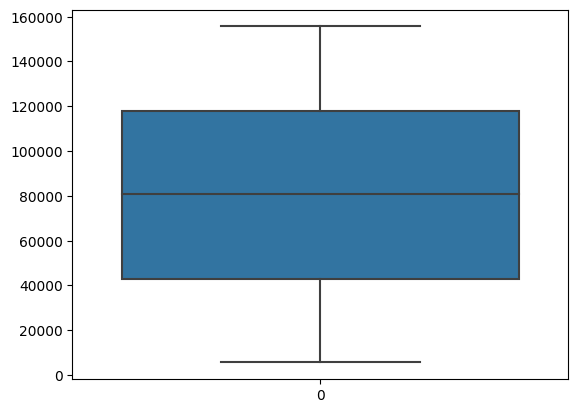

--------------------------------------------------


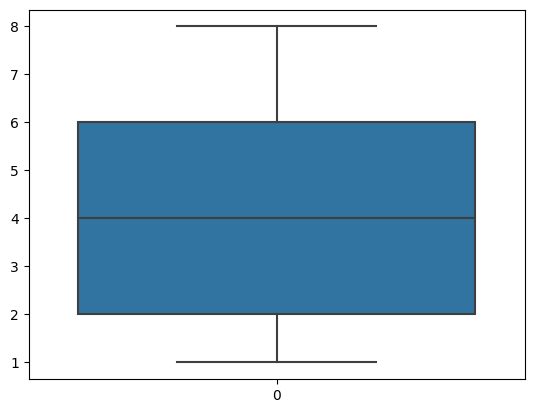

--------------------------------------------------


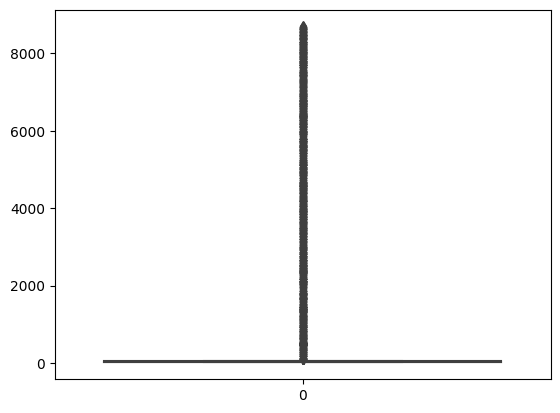

--------------------------------------------------


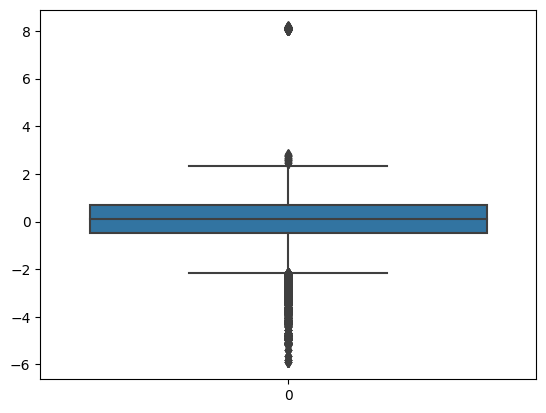

--------------------------------------------------


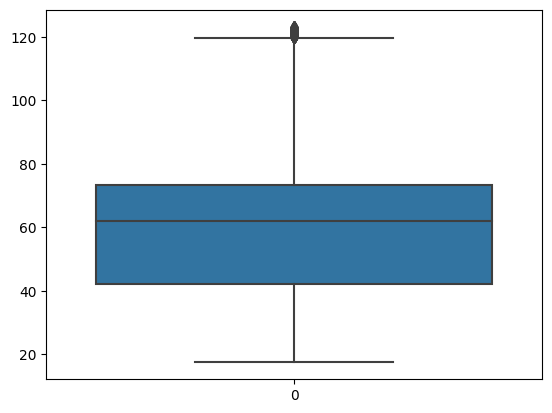

--------------------------------------------------


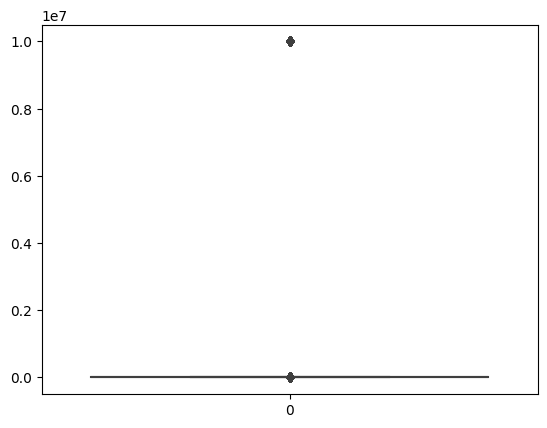

--------------------------------------------------


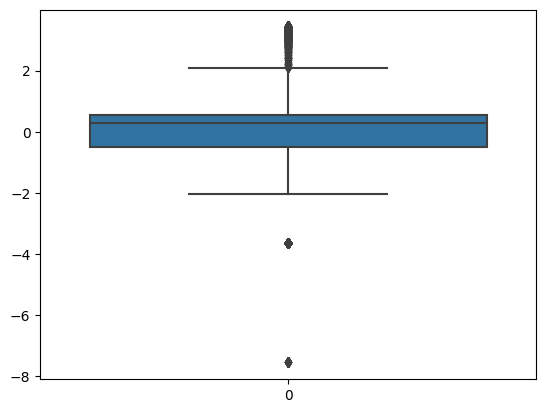

--------------------------------------------------


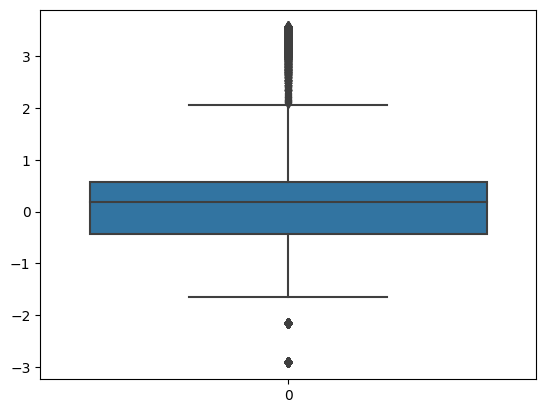

--------------------------------------------------


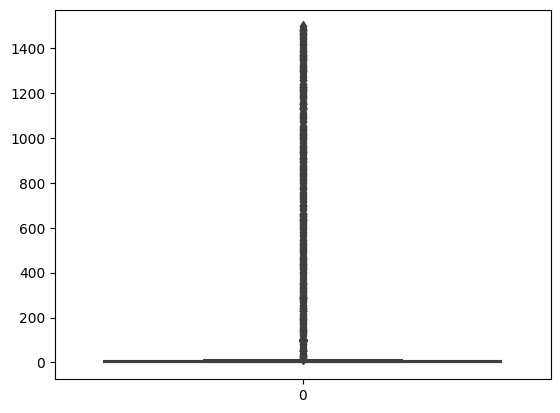

--------------------------------------------------


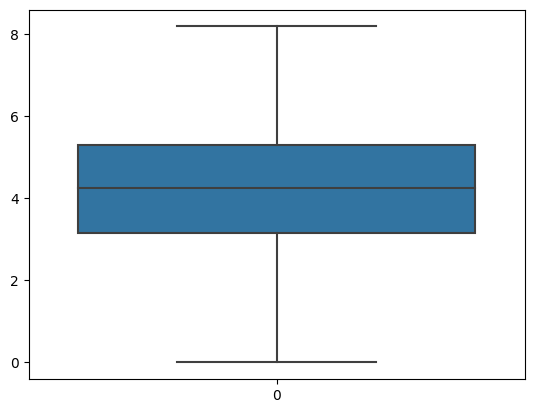

--------------------------------------------------


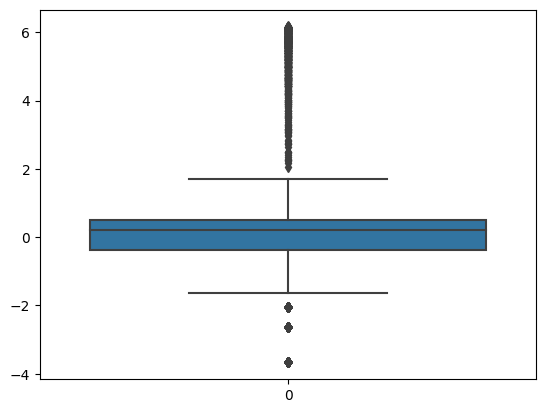

--------------------------------------------------


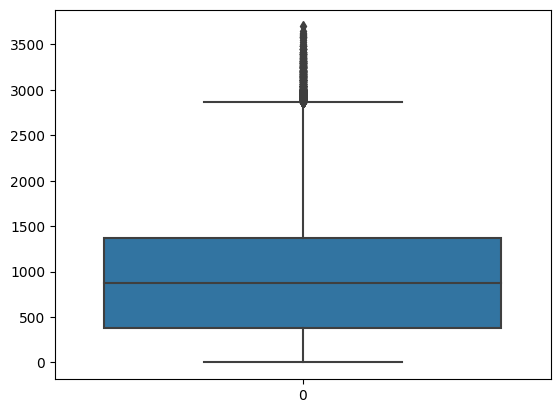

--------------------------------------------------


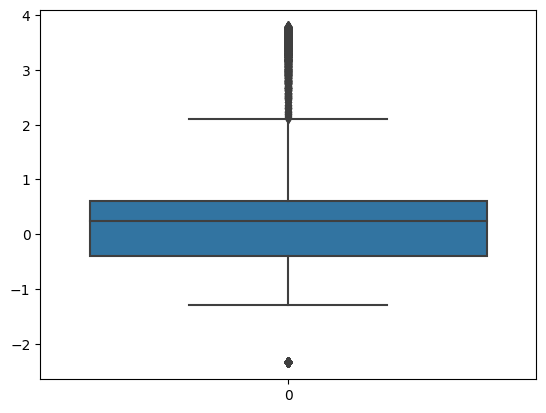

--------------------------------------------------


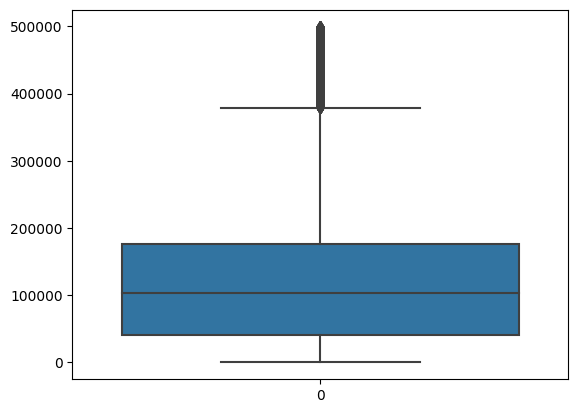

--------------------------------------------------


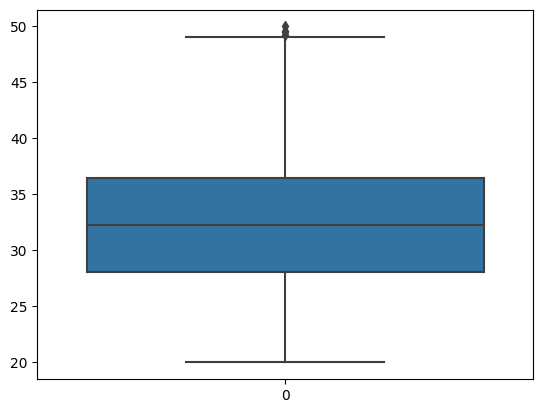

--------------------------------------------------


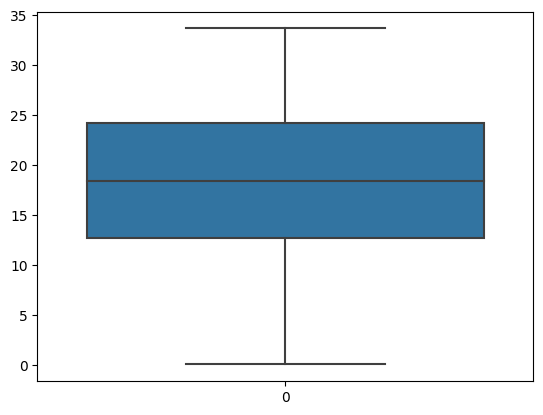

--------------------------------------------------


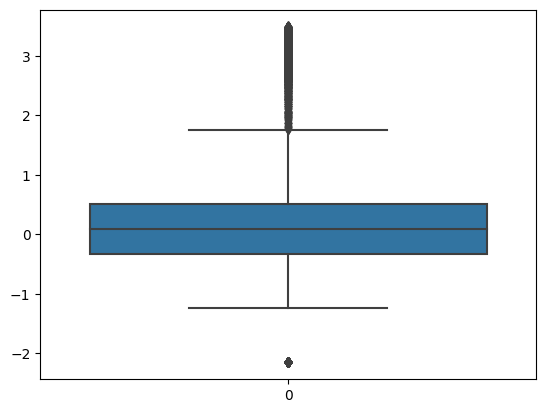

--------------------------------------------------


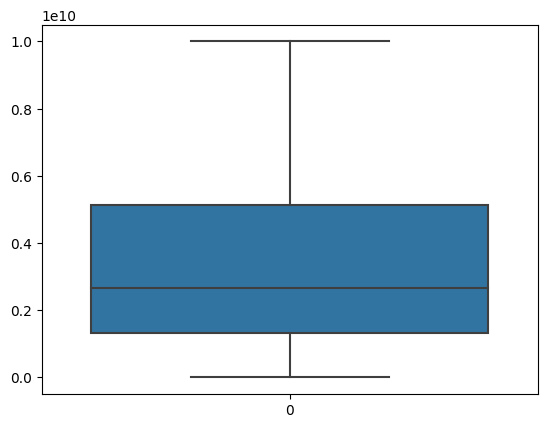

--------------------------------------------------


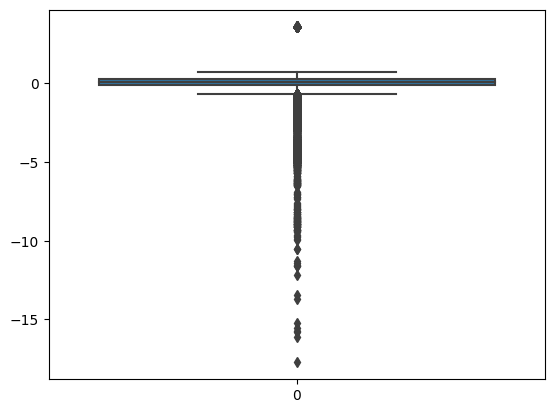

--------------------------------------------------


<Axes: >

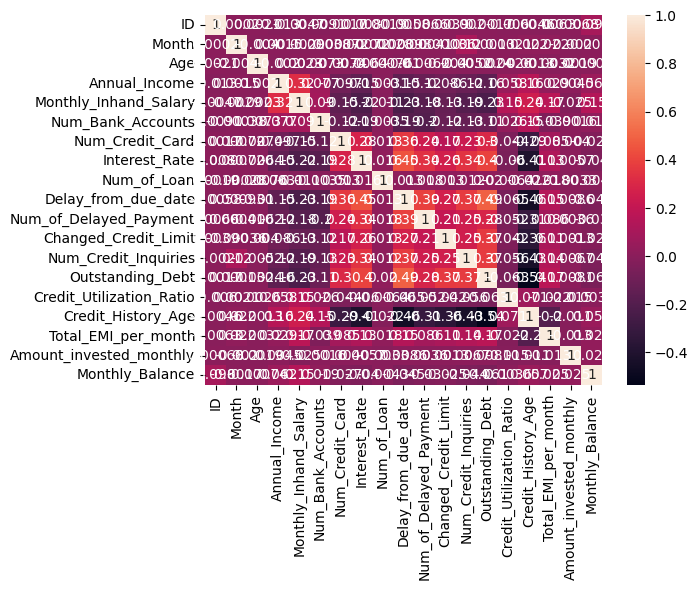

In [12]:
#test for outliers in data
for col in data_train.select_dtypes(include=['int64','float64']).columns:
    sns.boxplot(data_train[col])
    plt.show()
    print("--------------------------------------------------")

#check for correlation between variables
sns.heatmap(data_train.corr(),annot=True)

#check for correlation between variables and target variable
#data_train.corr()['Credit_Score'].sort_values(ascending=False)


In [13]:
outlier_cols = ['Total_EMI_per_month','Credit_Utilization_Ratio','Outstanding_Debt',
               'Num_Credit_Inquiries','Changed_Credit_Limit','Num_of_Delayed_Payment',
               'Interest_Rate','Num_Credit_Card','Num_Bank_Accounts',
               'Monthly_Inhand_Salary']


def treat_outliers(col):
    lower_limit, upper_limit = data_train[col].quantile([0.25,0.75])
    IQR = upper_limit - lower_limit
    lower_whisker = lower_limit - 1.5 * IQR
    upper_whisker = upper_limit + 1.5 * IQR
    return np.where(data_train[col]>upper_whisker,upper_whisker,np.where(data_train[col]<lower_whisker,lower_whisker,data_train[col]))


for col in outlier_cols:
    data_train[col] = treat_outliers(col)

In [14]:
#drop SSN column
data_train.drop('SSN',axis=1,inplace=True)
data_train.drop('Name',axis=1,inplace=True)


In [15]:
#treat the column - Type of Loan value before encoding
countOfLoan = data_train.Type_of_Loan.value_counts()
threshold = 500
remaining_categories = countOfLoan[countOfLoan <= threshold].index
loan_type_encoded = pd.get_dummies(data_train.Type_of_Loan.replace(remaining_categories,'Uncommon_Loan_Type'),dtype=np.int64)
loan_type_encoded

,AutoLoan,CreditBuilderLoan,DebtConsolidationLoan,HomeEquityLoan,MortgageLoan,NotSpecified,PaydayLoan,PersonalLoan,StudentLoan,Uncommon_Loan_Type
0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,1
99996,0,0,0,0,0,0,0,0,0,1
99997,0,0,0,0,0,0,0,0,0,1
99998,0,0,0,0,0,0,0,0,0,1


In [16]:
#check for categorical variables
cat_cols = data_train.select_dtypes(include=['object']).columns

from sklearn.preprocessing import LabelEncoder

def label_encode_categorical_columns(dataframe, columns):
    """
    Convert categorical columns in a dataframe to numerical values using label encoding.

    Arguments:
    dataframe -- Pandas DataFrame containing the data.
    columns -- List of column names to be label encoded.

    Returns:
    dataframe -- The modified dataframe with label encoded columns.
    """

    label_encoder = LabelEncoder()

    for column in columns:
        if column in dataframe.columns:
            dataframe[column] = label_encoder.fit_transform(dataframe[column])

    return dataframe


data_train = label_encode_categorical_columns(data_train,['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour','Credit_Score'])


# write a function to perform one hot encoding for column with categorical data type and select the top 10 features
def oneHotEncoding(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            top10 = [x for x in data[col].value_counts().sort_values(ascending=False).head(10).index]
            for label in top10:
                data[col+'_'+label] = np.where(data[col]==label,1,0)
            data.drop(col,axis=1,inplace=True)
    return data



data_train = oneHotEncoding(data_train)

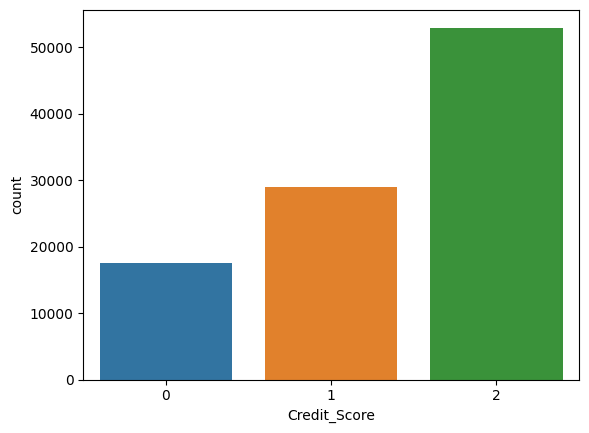

In [17]:
#Feature Splitting
X = data_train.drop('Credit_Score',axis=1)
y = data_train.Credit_Score

#check for imbalance classes
sns.countplot(x='Credit_Score',data=data_train);

In [18]:
#balcance the classes using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X,y = smote.fit_resample(X,y)


#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=100)


In [19]:
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif,k=10)
fs.fit_transform(X_train,y_train)
print(X.shape)

selected_features = fs.get_feature_names_out()
selected_features

#perform feature selection using RFE and RandomForestClassifier as estimator
final_selected_features = ['Annual_Income','Num_Credit_Card','Interest_Rate','Delay_from_due_date','Credit_Mix',
                           'Monthly_Balance','Credit_History_Age','Num_Credit_Inquiries','Changed_Credit_Limit','Num_of_Delayed_Payment',
                           'Outstanding_Debt','Monthly_Inhand_Salary','Payment_of_Min_Amount','Total_EMI_per_month','Payment_Behaviour']
X_train_final = X_train[final_selected_features]
X_test_final = X_test[final_selected_features]

(158865, 52)


In [20]:
#feature scaling and normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)


In [21]:
#make empty lists to store the accuracy scores of different models and model names
accuracy = []
model = []
precision = []
recall = []
f1 = []
#function to calculate the accuracy, precision, recall and f1 score of the model
def modelEvaluation(y_test,y_pred):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    accuracyScore = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracyScore)
    #accuracy.append(accuracyScore)
    precisionScore = precision_score(y_test,y_pred,average='weighted')
    #precision.append(precisionScore)
    print("Precison:", precisionScore)
    recallScore = recall_score(y_test,y_pred,average='weighted')
    #recall.append(recallScore)
    print("recall:", recallScore)
    f1Score = f1_score(y_test,y_pred,average='weighted')
    #f1.append(f1Score)
    print("f1:", f1Score)
    #model.append(str(model))

#function to plot the confusion matrix
def plotConfusionMatrix(y_test,y_pred):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#function to plot the ROC curve
def plotROC(y_test,y_pred):
    from sklearn.metrics import roc_curve,roc_auc_score
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print("ROC AUC Score : ",roc_auc_score(y_test,y_pred))

#function to plot the precision recall curve
def plotPrecisionRecall(y_test,y_pred):
    from sklearn.metrics import precision_recall_curve
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.plot(precision,recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()

#function to plot the learning curve
def plotLearningCurve(model):
    from sklearn.model_selection import learning_curve
    train_sizes,train_scores,test_scores = learning_curve(model,X_train,y_train,cv=5)
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))
    plt.xlabel('Train Sizes')
    plt.ylabel('Accuracy')
    plt.show()


In [22]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)

Accuracy: 0.42920089384068233
Precison: 0.4048788606256927
recall: 0.42920089384068233
f1: 0.38411526807597113


In [23]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# Set the maximum depth for the decision tree
import sys
sys.setrecursionlimit(10000)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#lotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)

Accuracy: 0.763100745916344
Precison: 0.7638893317808805
recall: 0.763100745916344
f1: 0.7634249550340146


In [24]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)

Accuracy: 0.8417839045730652
Precison: 0.8411983042775534
recall: 0.8417839045730652
f1: 0.8411997714359416


In [25]:
#XGBoost Classifier
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)

Accuracy: 0.8157869889528845
Precison: 0.8157847587938868
recall: 0.8157869889528845
f1: 0.8156163317680214


In [26]:
#Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)

Accuracy: 0.8365908161017216
Precison: 0.8359513545545255
recall: 0.8365908161017216
f1: 0.8359465562310028


In [ ]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)

In [ ]:
#SVM Classifier
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)


In [ ]:
#Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
modelEvaluation(y_test,y_pred)
#plotConfusionMatrix(y_test,y_pred)
#plotROC(y_test,y_pred)
#plotPrecisionRecall(y_test,y_pred)
#plotLearningCurve(model)